# Student 1: Air Quality Analysis
## Random Forest & XGBoost with SHAP Interpretability

This notebook applies machine learning methods to predict Air Quality Index (AQI) categories using environmental sensor data.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from models import MLModelTrainer, get_default_param_grids
from evaluation import ModelEvaluator, CrossValidationEvaluator
from interpretability import SHAPInterpreter, FeatureImportanceAnalyzer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data

In [2]:
print("Loading air quality dataset...")
df = pd.read_csv('../datasets/air_quality_data.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['aqi_category'].value_counts())
df.head()

Loading air quality dataset...
Dataset shape: (14447, 24)

Target distribution:
aqi_category
Moderate                   9272
Unhealthy_for_Sensitive    5047
Good                        123
Unhealthy                     5
Name: count, dtype: int64


,timestamp,country,city,station_type,temperature,humidity,wind_speed,precipitation,pm2.5,pm10,no2,co,o3,so2,aqi,aqi_category,hour,day_of_week,month,season,pm_ratio,pollution_index,is_weekend,is_rush_hour
0,2020-01-01 00:00:00,Belgium,Bruges,Industrial,20.22,33.85,5.42,1.23,38.38,53.33,30.49,0.418,53.27,10.70,109.67,Unhealthy_for_Sensitive,0.0,2.0,1.0,1.0,0.719670,40.733333,0,0
1,2020-01-01 01:00:00,France,Toulouse,Rural,18.09,34.29,7.61,0.00,18.39,25.05,24.59,0.426,43.20,0.76,61.48,Moderate,1.0,2.0,1.0,1.0,0.734132,22.676667,0,0
2,2020-01-01 02:00:00,Italy,Turin,Rural,14.78,41.11,5.79,5.95,29.44,42.04,31.27,0.402,70.26,4.96,84.12,Moderate,2.0,2.0,1.0,1.0,0.700285,34.250000,0,0
3,2020-01-01 04:00:00,France,Marseille,Industrial,19.80,40.86,2.92,0.00,32.03,36.87,24.11,0.554,41.81,11.43,91.52,Moderate,4.0,2.0,1.0,1.0,0.868728,31.003333,0,0
4,2020-01-01 05:00:00,Portugal,Braga,Urban_Background,24.02,24.92,23.80,0.74,35.21,41.11,39.53,0.422,46.76,4.77,100.60,Unhealthy_for_Sensitive,5.0,2.0,1.0,1.0,0.856483,38.616667,0,0


## 2. Feature Selection and Preparation

In [3]:
feature_cols = ['pm2.5', 'pm10', 'no2', 'co', 'o3', 'so2', 'temperature', 
                'humidity', 'wind_speed', 'precipitation', 'hour', 'day_of_week', 
                'month', 'season', 'pm_ratio', 'pollution_index', 'is_weekend', 'is_rush_hour']

X = df[feature_cols].copy()
y = df['aqi_category'].copy()

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"\nClass mapping:")
for idx, label in enumerate(le.classes_):
    print(f"  {idx}: {label}")

Features: 18
Samples: 14447

Class mapping:
  0: Good
  1: Moderate
  2: Unhealthy
  3: Unhealthy_for_Sensitive


## 3. Train-Test Split

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in training:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {le.classes_[u]}: {c} ({c/len(y_train)*100:.1f}%)")

Training set: (10112, 18)
Validation set: (2167, 18)
Test set: (2168, 18)

Class distribution in training:
  Good: 86 (0.9%)
  Moderate: 6490 (64.2%)
  Unhealthy: 3 (0.0%)
  Unhealthy_for_Sensitive: 3533 (34.9%)


## 4. Method 1: Random Forest Classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train, y_train)
print("✓ Random Forest training complete!")

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

print(f"\nTraining accuracy: {rf_model.score(X_train, y_train):.4f}")
print(f"Test accuracy: {rf_model.score(X_test, y_test):.4f}")

Training Random Forest Classifier...
✓ Random Forest training complete!

Training accuracy: 0.9897
Test accuracy: 0.9871


### Random Forest Evaluation

In [6]:
evaluator_rf = ModelEvaluator(task_type='classification')
metrics_rf = evaluator_rf.evaluate_classification(y_test, y_pred_rf, y_pred_proba_rf, average='weighted')

print("="*60)
print("RANDOM FOREST METRICS")
print("="*60)
print(f"Accuracy:           {metrics_rf['accuracy']:.4f}")
print(f"Precision (Weighted): {metrics_rf['precision']:.4f}")
print(f"Recall (Weighted):    {metrics_rf['recall']:.4f}")
print(f"F1-Score (Weighted):  {metrics_rf['f1_score']:.4f}")
print(f"Cohen's Kappa:       {metrics_rf['cohen_kappa']:.4f}")
print(f"Matthews Corr Coef:  {metrics_rf['matthews_corrcoef']:.4f}")
if 'auc_roc_ovr' in metrics_rf and metrics_rf['auc_roc_ovr'] is not None:
    print(f"AUC-ROC (OvR):       {metrics_rf['auc_roc_ovr']:.4f}")

RANDOM FOREST METRICS
Accuracy:           0.9871
Precision (Weighted): 0.9867
Recall (Weighted):    0.9871
F1-Score (Weighted):  0.9868
Cohen's Kappa:       0.9723
Matthews Corr Coef:  0.9723
AUC-ROC (OvR):       0.9919


In [7]:
evaluator_rf.print_classification_report(y_test, y_pred_rf, target_names=le.classes_)


CLASSIFICATION REPORT
                         precision    recall  f1-score   support

                   Good       1.00      0.79      0.88        19
               Moderate       0.99      0.99      0.99      1391
              Unhealthy       0.00      0.00      0.00         1
Unhealthy_for_Sensitive       0.98      0.99      0.98       757

               accuracy                           0.99      2168
              macro avg       0.74      0.69      0.71      2168
           weighted avg       0.99      0.99      0.99      2168



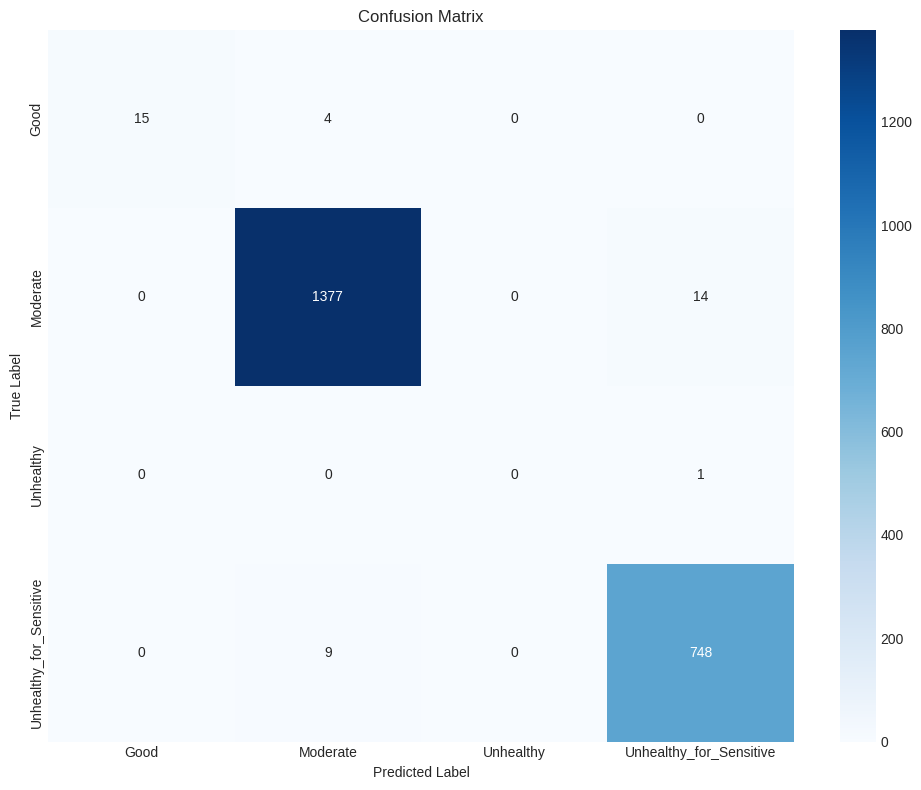

In [8]:
fig = evaluator_rf.plot_confusion_matrix(y_test, y_pred_rf, labels=le.classes_, figsize=(10, 8), normalize=False)
plt.savefig('../results/figures/rf_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Random Forest Cross-Validation

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

print("Performing 5-fold cross-validation for Random Forest...")
cv_results_rf = cross_validate(rf_model, X_train, y_train, cv=cv, scoring=scoring, 
                               return_train_score=True, n_jobs=-1)

cv_eval = CrossValidationEvaluator()
for metric in ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']:
    scores = cv_results_rf[f'test_{metric}']
    print(f"\n{metric.upper()}:")
    print(f"  Mean: {np.mean(scores):.4f}")
    print(f"  Std:  {np.std(scores):.4f}")
    print(f"  Scores: {[f'{s:.4f}' for s in scores]}")

Performing 5-fold cross-validation for Random Forest...


/home/durga/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/durga/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/durga/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



ACCURACY:
  Mean: 0.9851
  Std:  0.0029
  Scores: ['0.9876', '0.9802', '0.9832', '0.9871', '0.9871']

F1_WEIGHTED:
  Mean: 0.9848
  Std:  0.0030
  Scores: ['0.9874', '0.9799', '0.9830', '0.9871', '0.9869']

PRECISION_WEIGHTED:
  Mean: 0.9848
  Std:  0.0029
  Scores: ['0.9872', '0.9797', '0.9834', '0.9871', '0.9867']

RECALL_WEIGHTED:
  Mean: 0.9851
  Std:  0.0029
  Scores: ['0.9876', '0.9802', '0.9832', '0.9871', '0.9871']


## 5. Method 2: XGBoost Classifier

In [10]:
import xgboost as xgb

print("Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)
print("✓ XGBoost training complete!")

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

print(f"\nTraining accuracy: {xgb_model.score(X_train, y_train):.4f}")
print(f"Test accuracy: {xgb_model.score(X_test, y_test):.4f}")

Training XGBoost Classifier...
✓ XGBoost training complete!

Training accuracy: 1.0000
Test accuracy: 0.9862


### XGBoost Evaluation

In [11]:
evaluator_xgb = ModelEvaluator(task_type='classification')
metrics_xgb = evaluator_xgb.evaluate_classification(y_test, y_pred_xgb, y_pred_proba_xgb, average='weighted')

print("="*60)
print("XGBOOST METRICS")
print("="*60)
print(f"Accuracy:           {metrics_xgb['accuracy']:.4f}")
print(f"Precision (Weighted): {metrics_xgb['precision']:.4f}")
print(f"Recall (Weighted):    {metrics_xgb['recall']:.4f}")
print(f"F1-Score (Weighted):  {metrics_xgb['f1_score']:.4f}")
print(f"Cohen's Kappa:       {metrics_xgb['cohen_kappa']:.4f}")
print(f"Matthews Corr Coef:  {metrics_xgb['matthews_corrcoef']:.4f}")
if 'auc_roc_ovr' in metrics_xgb and metrics_xgb['auc_roc_ovr'] is not None:
    print(f"AUC-ROC (OvR):       {metrics_xgb['auc_roc_ovr']:.4f}")

XGBOOST METRICS
Accuracy:           0.9862
Precision (Weighted): 0.9858
Recall (Weighted):    0.9862
F1-Score (Weighted):  0.9858
Cohen's Kappa:       0.9703
Matthews Corr Coef:  0.9703
AUC-ROC (OvR):       0.9954


In [12]:
evaluator_xgb.print_classification_report(y_test, y_pred_xgb, target_names=le.classes_)


CLASSIFICATION REPORT
                         precision    recall  f1-score   support

                   Good       1.00      0.74      0.85        19
               Moderate       0.99      0.99      0.99      1391
              Unhealthy       0.00      0.00      0.00         1
Unhealthy_for_Sensitive       0.98      0.99      0.98       757

               accuracy                           0.99      2168
              macro avg       0.74      0.68      0.71      2168
           weighted avg       0.99      0.99      0.99      2168



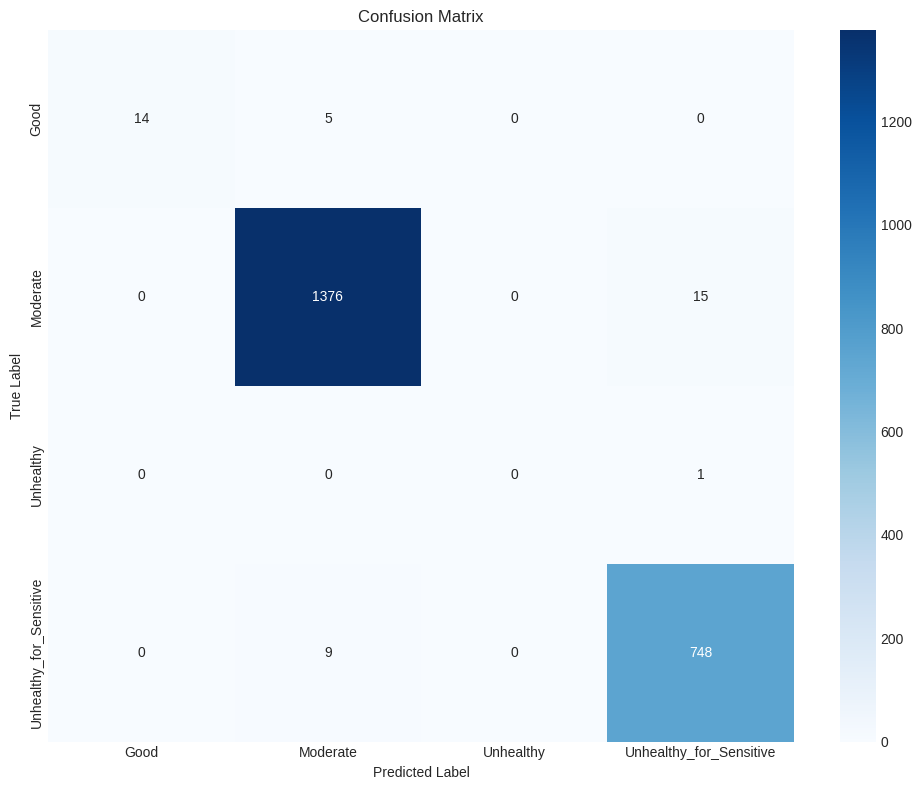

In [13]:
fig = evaluator_xgb.plot_confusion_matrix(y_test, y_pred_xgb, labels=le.classes_, figsize=(10, 8), normalize=False)
plt.savefig('../results/figures/xgb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### XGBoost Cross-Validation

In [14]:
print("Performing 5-fold cross-validation for XGBoost...")
cv_results_xgb = cross_validate(xgb_model, X_train, y_train, cv=cv, scoring=scoring, 
                                return_train_score=True, n_jobs=-1)

for metric in ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']:
    scores = cv_results_xgb[f'test_{metric}']
    print(f"\n{metric.upper()}:")
    print(f"  Mean: {np.mean(scores):.4f}")
    print(f"  Std:  {np.std(scores):.4f}")
    print(f"  Scores: {[f'{s:.4f}' for s in scores]}")

Performing 5-fold cross-validation for XGBoost...


/home/durga/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/durga/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/durga/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



ACCURACY:
  Mean: 0.9851
  Std:  0.0032
  Scores: ['0.9857', '0.9802', '0.9832', '0.9896', '0.9866']

F1_WEIGHTED:
  Mean: 0.9848
  Std:  0.0033
  Scores: ['0.9854', '0.9798', '0.9830', '0.9896', '0.9864']

PRECISION_WEIGHTED:
  Mean: 0.9848
  Std:  0.0033
  Scores: ['0.9851', '0.9796', '0.9833', '0.9896', '0.9862']

RECALL_WEIGHTED:
  Mean: 0.9851
  Std:  0.0032
  Scores: ['0.9857', '0.9802', '0.9832', '0.9896', '0.9866']


## 6. Model Comparison

In [15]:
results_dict = {
    'Random_Forest': metrics_rf,
    'XGBoost': metrics_xgb
}

comp_eval = ModelEvaluator(task_type='classification')
comparison_df = comp_eval.compare_models(results_dict)
print("\nModel Performance Comparison:")
print("="*60)
print(comparison_df)


Model Performance Comparison:
               accuracy precision    recall  f1_score cohen_kappa
Random_Forest  0.987085  0.986674  0.987085  0.986765    0.972267
XGBoost        0.986162  0.985764  0.986162  0.985781    0.970276


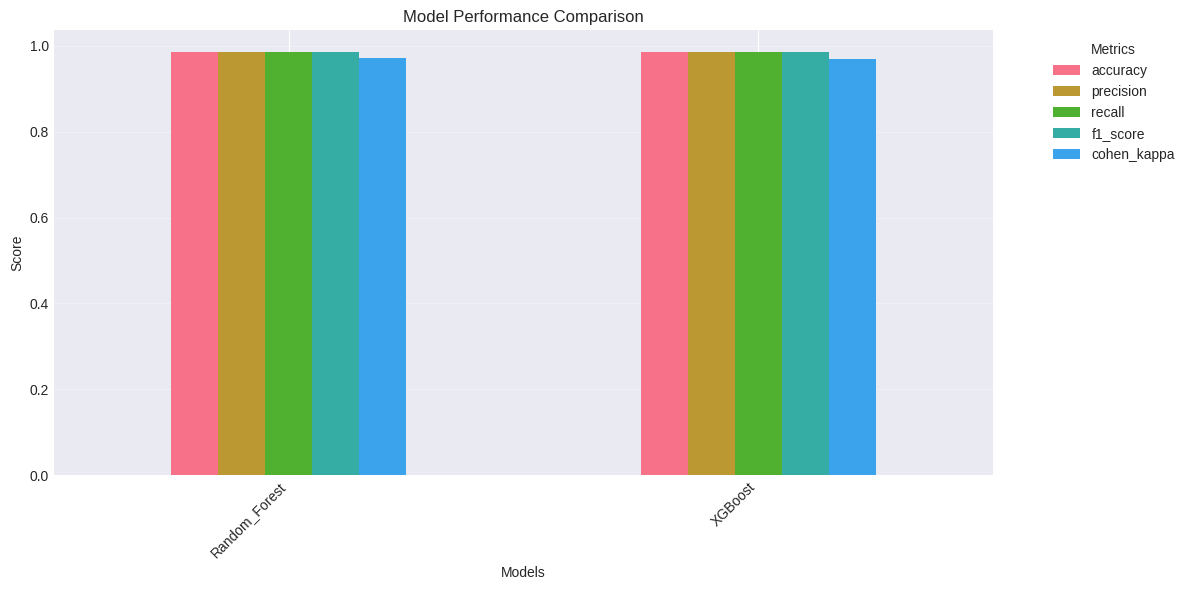

In [16]:
fig = comp_eval.plot_metrics_comparison(results_dict, 
                                        metrics_to_plot=['accuracy', 'precision', 'recall', 'f1_score', 'cohen_kappa'],
                                        figsize=(12, 6))
plt.savefig('../results/figures/student1_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. SHAP Interpretability Analysis

### SHAP for Random Forest

In [17]:
print("Calculating SHAP values for Random Forest...")
shap_rf = SHAPInterpreter(rf_model, X_train, model_type='tree')
shap_values_rf = shap_rf.calculate_shap_values(X_test[:500])
print("✓ SHAP values calculated!")

Calculating SHAP values for Random Forest...
✓ SHAP values calculated!


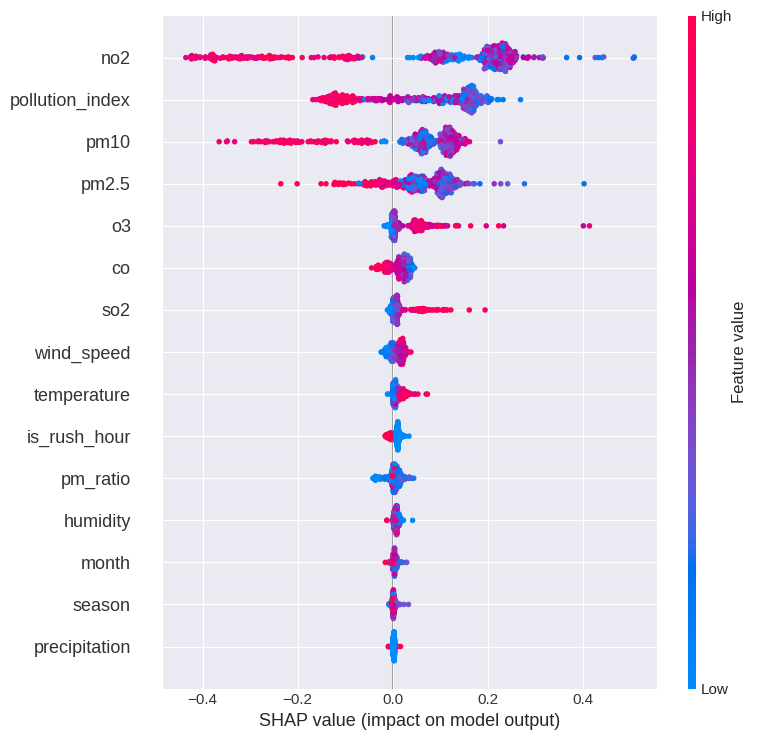

In [18]:
fig = shap_rf.plot_summary(X_test[:500], plot_type='dot', max_display=15, figsize=(12, 8))
plt.savefig('../results/figures/shap_rf_summary.png', dpi=300, bbox_inches='tight')
plt.show()

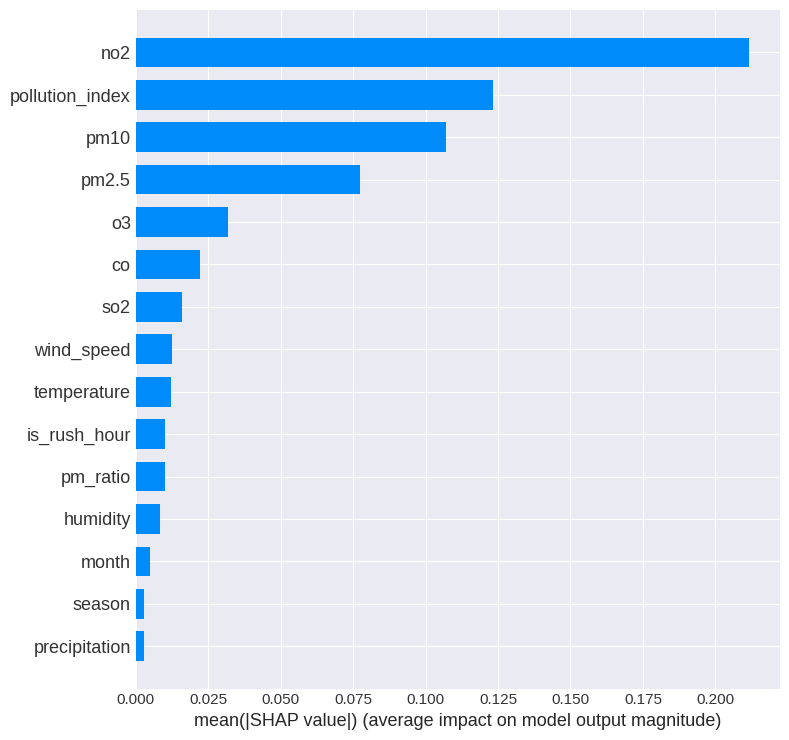

In [19]:
fig = shap_rf.plot_bar(X_test[:500], max_display=15, figsize=(10, 8))
plt.savefig('../results/figures/shap_rf_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
importance_rf = shap_rf.get_feature_importance(X_test[:500], top_n=15)
print("\nTop 15 Features by SHAP Importance (Random Forest):")
print(importance_rf)


Top 15 Features by SHAP Importance (Random Forest):
            feature  importance
2               no2    0.211693
15  pollution_index    0.123232
1              pm10    0.106977
0             pm2.5    0.077305
4                o3    0.032033
3                co    0.022346
5               so2    0.016058
8        wind_speed    0.012681
6       temperature    0.012264
17     is_rush_hour    0.010213
14         pm_ratio    0.010105
7          humidity    0.008311
12            month    0.004923
13           season    0.002934
9     precipitation    0.002855


### SHAP for XGBoost

In [21]:
print("Calculating SHAP values for XGBoost...")
shap_xgb = SHAPInterpreter(xgb_model, X_train, model_type='tree')
shap_values_xgb = shap_xgb.calculate_shap_values(X_test[:500])
print("✓ SHAP values calculated!")

Calculating SHAP values for XGBoost...
✓ SHAP values calculated!


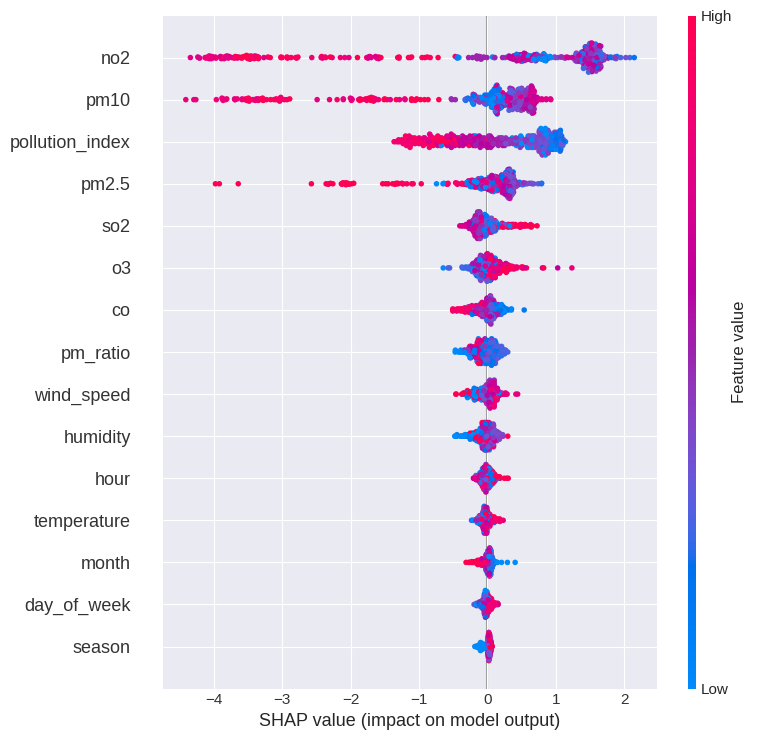

In [22]:
fig = shap_xgb.plot_summary(X_test[:500], plot_type='dot', max_display=15, figsize=(12, 8))
plt.savefig('../results/figures/shap_xgb_summary.png', dpi=300, bbox_inches='tight')
plt.show()

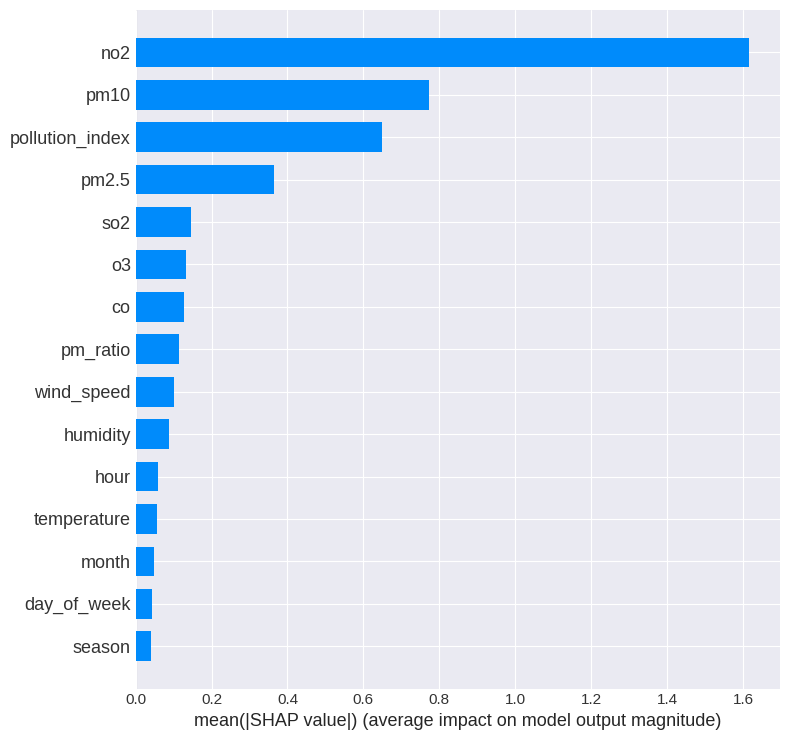

In [23]:
fig = shap_xgb.plot_bar(X_test[:500], max_display=15, figsize=(10, 8))
plt.savefig('../results/figures/shap_xgb_bar.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
importance_xgb = shap_xgb.get_feature_importance(X_test[:500], top_n=15)
print("\nTop 15 Features by SHAP Importance (XGBoost):")
print(importance_xgb)


Top 15 Features by SHAP Importance (XGBoost):
            feature  importance
2               no2    1.616714
1              pm10    0.772254
15  pollution_index    0.649070
0             pm2.5    0.365575
5               so2    0.145190
4                o3    0.131769
3                co    0.127252
14         pm_ratio    0.115199
8        wind_speed    0.100642
7          humidity    0.087503
10             hour    0.059991
6       temperature    0.055450
12            month    0.047332
11      day_of_week    0.043019
13           season    0.040848


## 8. Feature Importance Comparison

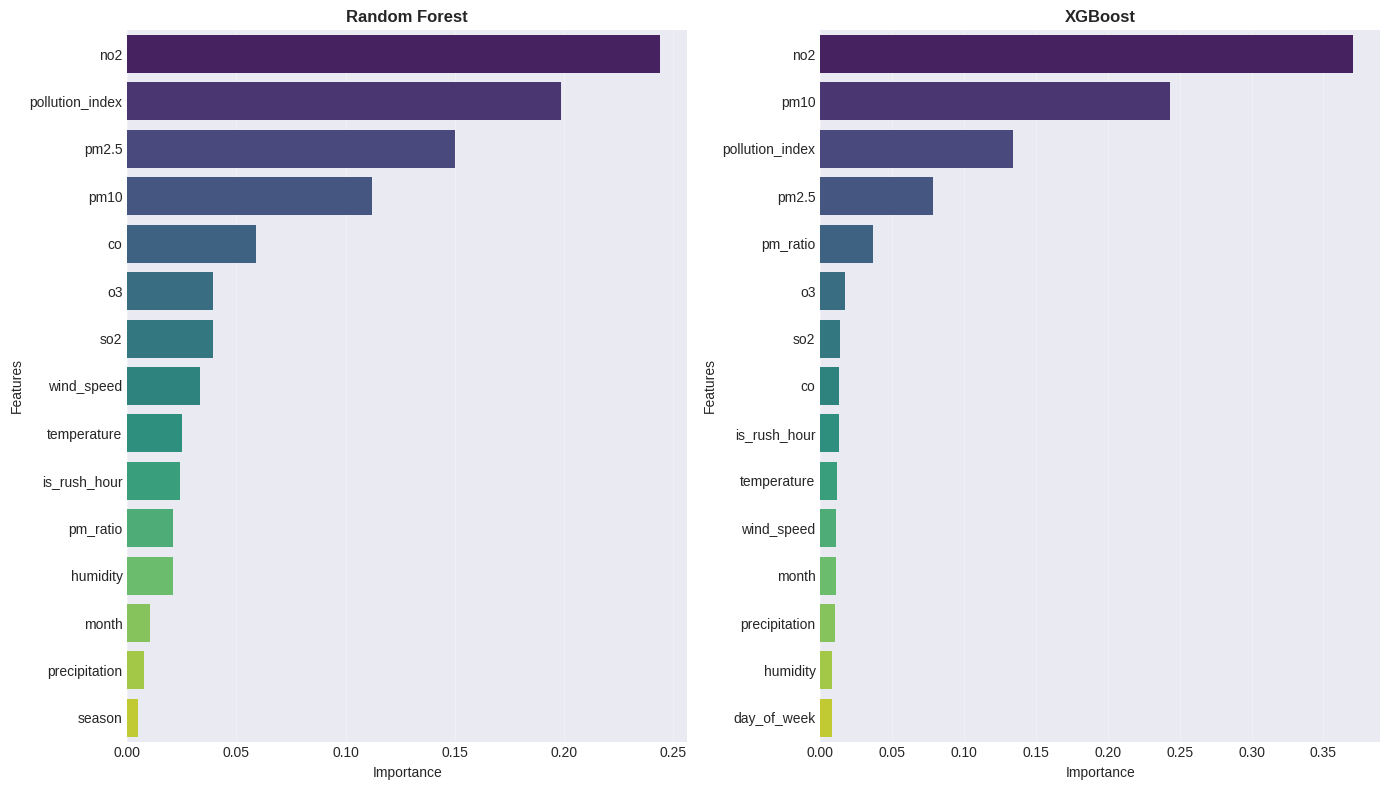

In [25]:
from interpretability import FeatureImportanceAnalyzer

rf_importance = FeatureImportanceAnalyzer.get_tree_importance(rf_model, feature_cols, top_n=15)
xgb_importance = FeatureImportanceAnalyzer.get_tree_importance(xgb_model, feature_cols, top_n=15)

fig = FeatureImportanceAnalyzer.compare_importances(
    {'Random Forest': rf_importance, 'XGBoost': xgb_importance},
    top_n=15,
    figsize=(14, 8)
)
plt.savefig('../results/figures/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Save Results

In [26]:
results_summary = {
    'random_forest': {
        'accuracy': float(metrics_rf['accuracy']),
        'precision': float(metrics_rf['precision']),
        'recall': float(metrics_rf['recall']),
        'f1_score': float(metrics_rf['f1_score']),
        'cohen_kappa': float(metrics_rf['cohen_kappa']),
        'matthews_corrcoef': float(metrics_rf['matthews_corrcoef'])
    },
    'xgboost': {
        'accuracy': float(metrics_xgb['accuracy']),
        'precision': float(metrics_xgb['precision']),
        'recall': float(metrics_xgb['recall']),
        'f1_score': float(metrics_xgb['f1_score']),
        'cohen_kappa': float(metrics_xgb['cohen_kappa']),
        'matthews_corrcoef': float(metrics_xgb['matthews_corrcoef'])
    }
}

import json
with open('../results/metrics/student1_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results saved to ../results/metrics/student1_results.json")

import pickle
with open('../results/models_student1.pkl', 'wb') as f:
    pickle.dump({'rf': rf_model, 'xgb': xgb_model, 'label_encoder': le}, f)

print("✓ Models saved to ../results/models_student1.pkl")

✓ Results saved to ../results/metrics/student1_results.json
✓ Models saved to ../results/models_student1.pkl


## 10. Summary

In [27]:
print("="*60)
print("STUDENT 1 ANALYSIS SUMMARY")
print("="*60)
print("\nMETHODS APPLIED:")
print("1. Random Forest Classifier")
print("2. XGBoost Classifier")
print("3. SHAP Interpretability Analysis")
print("\nKEY FINDINGS:")
print(f"- Best Model: {'Random Forest' if metrics_rf['f1_score'] > metrics_xgb['f1_score'] else 'XGBoost'}")
print(f"- Best F1-Score: {max(metrics_rf['f1_score'], metrics_xgb['f1_score']):.4f}")
print(f"- Best Accuracy: {max(metrics_rf['accuracy'], metrics_xgb['accuracy']):.4f}")
print(f"\n- Most Important Features (SHAP):")
for idx, row in importance_xgb.head(5).iterrows():
    print(f"  {idx+1}. {row['feature']}: {row['importance']:.4f}")
print("\n" + "="*60)

STUDENT 1 ANALYSIS SUMMARY

METHODS APPLIED:
1. Random Forest Classifier
2. XGBoost Classifier
3. SHAP Interpretability Analysis

KEY FINDINGS:
- Best Model: Random Forest
- Best F1-Score: 0.9868
- Best Accuracy: 0.9871

- Most Important Features (SHAP):
  3. no2: 1.6167
  2. pm10: 0.7723
  16. pollution_index: 0.6491
  1. pm2.5: 0.3656
  6. so2: 0.1452

